# 1. Import, install all necessary libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import uuid
from PIL import Image
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed

# For the Facenet model
import torch  # Ensure torch is imported here to avoid circular import issues
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms


/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Take about 30 min to download all of this based on your internet speed.

In [ ]:
#%pip install mtcnn

In [ ]:
#%pip install torch

In [ ]:
#%pip install facenet-pytorch

In [ ]:
#%pip install torchvision

In [ ]:
#%pip install --upgrade Pillow

# 2. Data Collection

Some obtain some data for our face verification system, we user some method:

- Use pre build datasets, as in this case, we use the LFW dataset.

- Use web scraping to collect data from the internet.

- Use video or image processing to collect data from the real world/ capture on webcam devices.

More details about each method:

- **In the first case, using pre build dataset**

Access this [link](http://vis-www.cs.umass.edu/lfw/) to download the LFW dataset. The dataset is composed of 13233 images of 5749 people. The dataset is devicded into many subfolders, each subfolder contains images of a specific person. Each image is named as the person's name and a number, size of the image is 250x250 pixels and in JPEG format.

Beside this dataset, we plan to use open source datasets provided by the University of Essex (face94, face95 and face96) if we have time and resources.

- **In the second case, collecting data from the internet using web scraping**

We use the below script to collect images from the internet using the `simple_image_download` library. Specify the person's name as the keyword, it will search for images of that person and download them to a folder named after the person's name. Note that using this, you will need to manually verify the images to ensure they are of the correct person.

```python
from simple_image_download import simple_image_download as simp

# from simp library call simple_image_download function
response = simp.simple_image_download

# the keywords that will be used to find pics, and each key work will create a different file 
keywords = ["George Wassouf", "Donald Trump", "Selena Gomez"]

# for loop on the keywords
# (kw, 1000) means 300 sample of each keyword 
for kw in keywords:
    response().download(kw, 1000) 
```


- **In the third case, we can use OpenCV to capture images from a webcam or a video**

```python
import cv2
import os

# Input Path
video_path = '/home/jawabreh/Desktop/face_scan.MOV'

# Output Path
output_dir = '/home/jawabreh/Desktop/face-recognition/training/person_1'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create a VideoCapture object to read the input video
cap = cv2.VideoCapture(video_path)

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate the frame interval to capture for 150 images
frame_interval = total_frames // 1000 # change this number according to your needs 

# Set the initial frame counter to 0
frame_counter = 0

while cap.isOpened():
    # Read a frame from the video
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Check if this is the frame to capture
    if frame_counter % frame_interval == 0 and frame_counter // frame_interval < 1000:
        # Save the frame as a JPEG image
        output_path = os.path.join(output_dir, f'{frame_counter//frame_interval + 1:03}.jpg')
        cv2.imwrite(output_path, frame)
    
    # Increment the frame counter
    frame_counter += 1
    
    if frame_counter >= total_frames:
        break

# Release the video capture object
cap.release()
print("\n\nDONE\n\n")
```



Currently, we are just testing on the LWF dataset, but use the second and third methods can be use to enhace the diversity or specific data we need for our face verification system. Most of iamges inside the LWF dataset are people in Western countries, so we can use the second and third methods to collect images of people from our specific region or country. This will help the model perfrom better on our target market.

In [6]:
# # Incase you want to run this notebook on your machine, but the size of LWF dataset overwhelms your machine, 
# # you can run the following code delete some random subfolders from the dataset, only keeping as you want.



# # Path to the directory containing subfolders
# lfw_dir = './lfw' # REPLACE WITH YOUR PATH to the LFW dataset (after extracting the zip file)
# # In my case, it located in the same directory as this notebook

# # Get a list of all subfolders
# subfolders = [f.path for f in os.scandir(lfw_dir) if f.is_dir()]

# # Shuffle the list of subfolders
# random.shuffle(subfolders)

# # Keep only 20 subfolders
# subfolders_to_keep = subfolders[:20]

# # Delete the remaining subfolders
# for subfolder in subfolders[20:]:
#     for root, dirs, files in os.walk(subfolder, topdown=False):
#         for name in files:
#             os.remove(os.path.join(root, name))
#         for name in dirs:
#             os.rmdir(os.path.join(root, name))
#     os.rmdir(subfolder)

# print(f"Kept {len(subfolders_to_keep)} subfolders and deleted the rest.")

# # Then rename the lfw dataset folder to 'data' folder
# os.rename(lfw_dir, 'data')
# print("Renamed the 'lfw' folder to 'data'.")


After that, observe the `data` folder, you will see subfolders named after the person's name, each subfolder contains images of that person.

# 3. Face Detection

We will use the images of faces inside `data` folder as input for the face detection algorithm. The algorithm takes a  the input image and detects faces in each image within the training folders, generating a .npz file which is a file format used in Python for storing and retrieving large numerical arrays and matrices.

For the face detection task in our system, we will be employing the MTCNN algorithm, which stands for Multi-Task Cascaded Convolutional Neural Network. This deep learning algorithm is commonly used for face detection and facial recognition tasks. MTCNN uses a cascading approach to detect faces and facial features such as the eyes, nose, and mouth. 


In this task, we will create a folder name `preprocessed_data` at the same level as the `data` folder. The `preprocessed_data` folder will contain two subfolders: face_detect and face_embeddings.

- The `face_detect` folder will contain the images with the faces extracted from the original images. Inside there are many subfolder with the name of the person, each subfolder contains the images of faces extracted from that person images. Also, compressed all faces imgages inside a subfolder into a single .npz file inside that subfolder. (Actually, the faces images are just for visualization, the model will just need to read the faces represents by numpy arrays in the .npz file to work with).

- The `face_embeddings` folder will contain the .npz files that contain the embeddings of the faces. Each .npz file will contain the embeddings of the faces of a specific person. The embeddings are generated by a pre-trained model, in this case, we will use the FaceNet model. The FaceNet model is a deep learning model that generates embeddings for faces. The embeddings are numerical representations of the faces that can be used for face recognition tasks.


![DataFolderStructure.drawio.png](resources/images/DataFolderStructure.drawio.png)

In [15]:
# Create preprocessed_data folder
os.makedirs('preprocessed_data', exist_ok=True)

# Inside that folder, create face_detect folder and face_embeddings folder
os.makedirs(os.path.join('preprocessed_data', 'face_detect'), exist_ok=True)
os.makedirs(os.path.join('preprocessed_data', 'face_embeddings'), exist_ok=True)

# The final outcome of this notebook will be the embeddings of the faces in the dataset, meanin the face_embeddings folder. The face_detect folder serves as an intermediate step to store the extracted faces from the images.

In [18]:
# Detect and extract faces from an image using MTCNN
# Parameters:
# - image_path: path to the image file
# - detector: MTCNN detector object
# - required_size: the size of the extracted face images (default is (160, 160))
def detect_and_extract_faces(image_path, detector, required_size=(160, 160)):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    detections = detector.detect_faces(image_np)
    faces = []
    for detection in detections:
        x, y, width, height = detection['box']
        face = image_np[y:y+height, x:x+width]
        face_image = Image.fromarray(face).resize(required_size)
        faces.append(np.array(face_image))
    return faces

# Process a single subfolder (since the data folder contains subfolders for each person, use this function to process each subfolder)
# Parameters:
# - subfolder: the subfolder name in data folder we want to process
# - face_only_dataset_dir: the directory to save the extracted faces. This is the subfolder with person's name inside the face_detect folder

# - detector: MTCNN detector object
def process_subfolder(subfolder, face_only_dataset_dir, detector):
    subfolder_path = os.path.join('./data', subfolder) #Acessing the subfolder
    new_faces_folder = os.path.join(face_only_dataset_dir, os.path.basename(subfolder))
    
    # Create the new_faces_folder if it does not exist
    os.makedirs(new_faces_folder, exist_ok=True)
    
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')] # For all images inside a person folder in the subfolder 
    faces = []
    
    for image_file in image_files:
        image_path = os.path.join(subfolder_path, image_file)
        extracted_faces = detect_and_extract_faces(image_path, detector)
        
        for i, face in enumerate(extracted_faces):
            face_image = Image.fromarray(face)
            face_image_path = os.path.join(new_faces_folder, f'{os.path.splitext(image_file)[0]}_face_{i+1}.jpg')
            face_image.save(face_image_path)
        
        faces.extend(extracted_faces)
    
    # Ensure all faces have the same shape before saving to .npz
    if faces:
        face_shape = faces[0].shape
        faces = [face for face in faces if face.shape == face_shape]
        faces = np.array(faces)
        savez_compressed(os.path.join(new_faces_folder, 'faces.npz'), faces)



`faces.npz` is just simply a compressed file that contains all list of numpy arrays, where each numpy array is a face image. 

In [19]:

# Main function to process all subfolders

detector = MTCNN()

for subfolder in os.listdir('./data'):
    print("Processing face detection for:", subfolder)
    process_subfolder(subfolder, './preprocessed_data/face_detect', detector)

Processing face detection for: Steve_Avery
Processing face detection for: Nigel_Redden
Processing face detection for: Chang_Saio-yue
Processing face detection for: Hussein_Malik
Processing face detection for: Ali_Adbul_Karim_Madani
Processing face detection for: Sebastien_Grosjean
Processing face detection for: Lionel_Chalmers
Processing face detection for: Roger_Machado
Processing face detection for: Sonja_Kesselschlager
Processing face detection for: Zhang_Yimou
Processing face detection for: Claudia_Schiffer
Processing face detection for: Tzipora_Obziler
Processing face detection for: Miguel_Cotto
Processing face detection for: Scott_Hoch
Processing face detection for: Thomas_Malchow
Processing face detection for: Joel_Gallen
Processing face detection for: Corey_Maggette
Processing face detection for: Anne_ONeil
Processing face detection for: Kim_Jin-sun
Processing face detection for: Nora_Ephron


First subfolder: Steve_Avery
Keys in the .npz file: ['arr_0']
Shape of faces array: (1, 160, 160, 3)
Shape of the first face: (160, 160, 3)


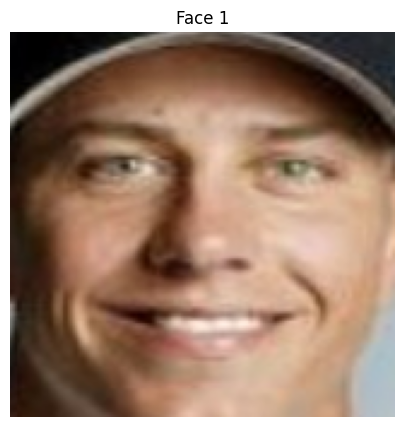

In [26]:
# Testing: load a faces.npz file in the first subfolder and display the faces

# Get the path to the first subfolder
first_subfolder = os.listdir('./preprocessed_data/face_detect')[0]
print("First subfolder:", first_subfolder)

# Load the .npz file
npz_file_path = os.path.join('./preprocessed_data/face_detect', first_subfolder, 'faces.npz')
test = np.load(npz_file_path)

# Print the keys in the .npz file
print("Keys in the .npz file:", test.files)

# Extract the faces array
faces = test['arr_0']

# Print the shape of the faces array
print("Shape of faces array:", faces.shape)

# Print the shape of the first face
face_shape = faces[0].shape
print("Shape of the first face:", face_shape)

# Plot the faces
plt.figure(figsize=(20, 5))
for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.axis('off')
    plt.title(f"Face {i+1}")
    plt.imshow(face)
plt.show()

# 4. Features Extraction



Cut sang mot file moi

Face feature extraction is a crucial step in face recognition systems. It involves transforming the raw image data of a face into a high-dimensional feature vector, which can be used to represent the unique facial characteristics of an individual. The feature extraction process aims to identify the most informative and discriminative facial features, such as the shape, texture, and color of facial components like eyes, nose, and mouth.

In our system we will use FaceNet algorithm which is a deep learning algorithm used for feature extraction in face recognition systems. Make sure you already run the following command that I put at te beginning of the notebook to install the necessary model. In this case, we use te Facenet model from Pytorch. It may take a while to download the model, so be patient.

In [29]:
# Load the pre-trained FaceNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Define a function to generate embeddings
# Parameters:
# - image_array: a numpy array representing the image
def generate_embedding(image_array):
    # Convert numpy array to PIL image
    image = Image.fromarray(image_array)
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    # Generate embedding
    with torch.no_grad():
        embedding = model(img_tensor).cpu().numpy()
    return embedding

# Process a single subfolder
# Parameters:
# - subfolder: the subfolder name in face_only_dataset we want to process
# - embedding_dir: the directory to save the embeddings. This is the subfolder with person's name inside the face_embeddings folder
def process_subfolder_for_embeddings(subfolder, embedding_dir):
    subfolder_path = os.path.join('./preprocessed_data/face_detect', subfolder)
    new_embedding_folder = os.path.join(embedding_dir, os.path.basename(subfolder))
    
    os.makedirs(new_embedding_folder, exist_ok=True)
    
    # Load faces from the .npz file
    data = np.load(os.path.join(subfolder_path, 'faces.npz'))
    faces = data['arr_0']
    
    embeddings = []
    
    for face in faces:
        embedding = generate_embedding(face)
        embeddings.append(embedding)
    
    # Save embeddings to a .npz file
    embeddings = np.array(embeddings)
    savez_compressed(os.path.join(new_embedding_folder, 'embeddings.npz'), embeddings)



In [30]:
# Main function to process all subfolders
for subfolder in os.listdir('./preprocessed_data/face_detect'):
    print("Extracted features for:", subfolder)
    process_subfolder_for_embeddings(subfolder, './preprocessed_data/face_embeddings')

Extracted features for: Steve_Avery
Extracted features for: Nigel_Redden
Extracted features for: Chang_Saio-yue
Extracted features for: Hussein_Malik
Extracted features for: Ali_Adbul_Karim_Madani
Extracted features for: Sebastien_Grosjean
Extracted features for: Lionel_Chalmers
Extracted features for: Roger_Machado
Extracted features for: Sonja_Kesselschlager
Extracted features for: Zhang_Yimou
Extracted features for: Claudia_Schiffer
Extracted features for: Tzipora_Obziler
Extracted features for: Miguel_Cotto
Extracted features for: Scott_Hoch
Extracted features for: Thomas_Malchow
Extracted features for: Joel_Gallen
Extracted features for: Corey_Maggette
Extracted features for: Anne_ONeil
Extracted features for: Kim_Jin-sun
Extracted features for: Nora_Ephron


In [31]:
# Show an example of the embeddings

# first, load the first subfolder inside the face_embeddings folder
first_subfolder = os.listdir('./preprocessed_data/face_embeddings')[0]
print("First subfolder:", first_subfolder)

# Load the .npz file
npz_file_path = os.path.join('./preprocessed_data/face_embeddings', first_subfolder, 'embeddings.npz')
test = np.load(npz_file_path)

# Print the keys in the .npz file
print("Keys in the .npz file:", test.files)

# Extract the embeddings array
embeddings = test['arr_0']

# Print the shape of the embeddings array
print("Shape of embeddings array:", embeddings.shape)

# Print the first embedding
print("First embedding:", embeddings[0])


First subfolder: Steve_Avery
Keys in the .npz file: ['arr_0']
Shape of embeddings array: (1, 1, 512)
First embedding: [[ 4.34926413e-02  1.84008684e-02  9.02262479e-02 -5.76370358e-02
   4.32112766e-03  1.32416030e-02 -4.89876010e-02 -5.12719899e-02
   6.28201142e-02  6.38221726e-02 -6.15599379e-02  5.34055308e-02
  -5.15498593e-02  1.59400254e-02 -3.03269201e-03  4.66904901e-02
   3.19185667e-02 -4.15191688e-02 -4.39127162e-03  4.78814989e-02
   2.34462339e-02  3.46223637e-02  8.20611790e-02  4.23667356e-02
  -1.97510198e-02  3.70151550e-02  3.97661440e-02  2.83952318e-02
  -4.11047973e-02 -5.92801645e-02 -2.86901295e-02  6.03817776e-03
  -7.04172393e-03  8.99829809e-03  4.07153144e-02  3.10711078e-02
   5.81507534e-02 -1.74928561e-03  8.19189381e-03 -1.32462252e-02
   6.55876994e-02 -5.26745766e-02  5.07635698e-02  5.72572276e-03
  -5.21870740e-02  3.43771316e-02  1.59188751e-02  7.72914197e-03
  -3.67292166e-02  5.76104261e-02  1.03484102e-01  4.01279256e-02
  -8.19208920e-02 -3.666

#  5. Train classifier model for face verification

To prepare the data for training a classifier in the verification process, you need to create pairs of embeddings and corresponding labels indicating whether the pairs are from the same person or different persons. Here's the step-by-step idea:

Steps to Prepare Data for Training the Classifier
Load Embeddings:

Load the embeddings from the .npz files stored in each subfolder.
Create Pairs:

Create pairs of embeddings:
Positive Pairs: Pairs of embeddings from the same person.
Negative Pairs: Pairs of embeddings from different persons.
Generate Labels:

Assign labels to the pairs:
Positive Pairs: Label as 1 (indicating the same person).
Negative Pairs: Label as 0 (indicating different persons).
Prepare Training Data:

Combine the pairs and labels into a format suitable for training a classifier.
Detailed Steps
Load Embeddings:

Iterate through each subfolder in the _embedding_by_facenet directory and load the embeddings.
Create Pairs:

For each person, create positive pairs by pairing each embedding with every other embedding in the same subfolder.
Create negative pairs by pairing each embedding with embeddings from different subfolders.
Generate Labels:

Assign 1 to positive pairs and 0 to negative pairs.
Prepare Training Data:

Combine the pairs and labels into arrays or a DataFrame for training.


However,  inside a subfolder, make a pair from embedding in embeding.npz of that file is oke, sinnce a subfolder contain only a few images-. only a few embedding vector inside a embedding.npz, but for the negative pair when combine a embedding vector in this sub folder to all other embedding in embedding.npz inside all other subfolder will be enormus, like euqal n! with n is total number of images inside the dataset. SO i think just randomly select in negative iamges, you can limit, randomly choose number of embedding vectors to combine in each emberdding.npz subfolder and also the number of subfolder to take embedding.npz to combine





Steps to Create Pairs with Random Sampling for Negative Pairs
Load Embeddings:

Load the embeddings from the .npz files stored in each subfolder.
Create Positive Pairs:

Create pairs of embeddings from the same subfolder (positive pairs).
Create Negative Pairs with Random Sampling:

Randomly select a limited number of embeddings from other subfolders to create negative pairs.
Generate Labels:

Assign labels to the pairs: 1 for positive pairs and 0 for negative pairs.
Prepare Training Data:

Combine the pairs and labels into arrays for training.

In [13]:
import random

# Load embeddings from the .npz files
def load_embeddings(embedding_dir):
    embeddings_dict = {}
    for subfolder in os.listdir(embedding_dir):
        subfolder_path = os.path.join(embedding_dir, subfolder)
        if os.path.isdir(subfolder_path):
            data = np.load(os.path.join(subfolder_path, 'embeddings.npz'))
            embeddings = data['arr_0']
            embeddings_dict[subfolder] = embeddings
    return embeddings_dict

# Create pairs of embeddings and corresponding labels
def create_pairs(embeddings_dict, num_negative_samples=5, num_subfolders_to_sample=3):
    pairs = []
    labels = []
    persons = list(embeddings_dict.keys())
    
    # Create positive pairs
    for person in persons:
        embeddings = embeddings_dict[person]
        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                pairs.append([embeddings[i], embeddings[j]])
                labels.append(1)
    
    # Create negative pairs with random sampling
    for person in persons:
        embeddings = embeddings_dict[person]
        other_persons = [p for p in persons if p != person]
        sampled_persons = random.sample(other_persons, min(num_subfolders_to_sample, len(other_persons)))
        
        for emb in embeddings:
            for sampled_person in sampled_persons:
                sampled_embeddings = embeddings_dict[sampled_person]
                sampled_negative_embeddings = random.sample(list(sampled_embeddings), min(num_negative_samples, len(sampled_embeddings)))
                
                for neg_emb in sampled_negative_embeddings:
                    pairs.append([emb, neg_emb])
                    labels.append(0)
    
    return np.array(pairs), np.array(labels)

# Load embeddings
embedding_dir = './embedding_by_facenet'
embeddings_dict = load_embeddings(embedding_dir)

# Create pairs and labels with random sampling for negative pairs
pairs, labels = create_pairs(embeddings_dict, num_negative_samples=5, num_subfolders_to_sample=3)

# Prepare data
X = np.array([np.concatenate(pair) for pair in pairs])
y = labels

print("Shape of training data:", X.shape)
print("Shape of labels:", y.shape)

Shape of training data: (1323, 2, 512)
Shape of labels: (1323,)


```plaintext
Shape of training data: (1321, 2, 512)
Shape of labels: (1321,)
```

The output indicates the dimensions of two different datasets: the training data and the labels.

Shape of training data: (1321, 2, 512)

1321: This is the number of samples in your training dataset.
2: This could represent the number of channels, features, or some other dimension depending on your specific use case.
512: This is likely the length of each feature vector or sequence.
Together, this means you have 1321 samples, each with 2 features or channels, and each feature or channel has 512 elements.

Shape of labels: (1321,)

1321: This indicates that there is one label for each of the 1321 samples in your training data.
In summary, you have a training dataset with 1321 samples, each sample having a 2x512 structure, and a corresponding label for each sample.

In [14]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# train an SVM model
from sklearn.discriminant_analysis import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import pickle

# print("Shape of training data:", X_train.shape)
# # Flatten the training data
# X_train_flatten = X_train.reshape(X_train.shape[0], -1)

# # Check the new shape
# print("Shape of flattened training data:", X_train_flatten.shape)


# # Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_flatten)

# # Train the SVM model
# svm_model = SVC(kernel='linear', probability=True)
# svm_model.fit(X_train_scaled, y_train)

# # Save the scaler and the SVM model separately

# # Create a directory to save the models
# # Create a directory to save the models
# model_dir = './model_saved'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# with open(os.path.join(model_dir, 'scaler.pkl'), 'wb') as f:
#     pickle.dump(scaler, f)

# with open(os.path.join(model_dir, 'svm_model.pkl'), 'wb') as f:
#     pickle.dump(svm_model, f)



In [16]:
# # Evaluate the model
# train_accuracy = model.score(X_train, y_train)

# # Flatten the testing data
# X_test = X_test.reshape(X_test.shape[0], -1)

# test_accuracy = model.score(X_test, y_test)

# # plot the taining and testing accuracy
# plt.figure(figsize=(8, 5))
# plt.bar(['Training Accuracy', 'Testing Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
# plt.ylabel('Accuracy')
# plt.title('Training and Testing Accuracy of SVM Model')
# plt.ylim(0, 1)
# plt.show()



In [17]:
# # Plot the confusion matrix
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# # Predict the labels
# y_pred = model.predict(X_test)

# # Create a confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# #plot the matrix
# plt.figure(figsize=(5, 5))
# sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=['Different', 'Same'], yticklabels=['Different', 'Same'])
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [18]:
# #  Store the model
# import pickle

# # Save the model
# #create model_saved directory

# model_dir = './model_saved'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# model_path = os.path.join(model_dir, 'svm_model.pkl')

# with open(model_path, 'wb') as file:
#     pickle.dump(model, file)


In [19]:
# # Load model from the saved file
# import pickle
# model_path = './model_saved/svm_model.pkl'
# with open(model_path, 'rb') as file:
#     model = pickle.load(file)

In [21]:
# Load the scaler and the SVM model

# Load the scaler and the SVM model
with open('./model_saved/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('./model_saved/svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

# Flatten and standardize the test data
X_test_flatten = X_test.reshape(X_test.shape[0], -1)
X_test_scaler = scaler.transform(X_test_flatten)

# Predict using the SVM model
predictions = svm_model.predict(X_test_scaler)

# Demo

Now is the demo part, create a test_validation folder. then use open cv to open the webcam, first ask the user for their name, then creata subfolder inside the test_validation/user_provided_name and store scanning image of that person(eg: when user press p then capture a picture of them). Then after that, create a function, using open cv to connect to camera, take the frame when user, then detect face, extract features then compare will all images inside thier scanning (with subfolder with correspoding naem). I thing for best optimize, right efter sacnning process, those images will be detectface, store to face.npz and then ec=xtractfeatures, store to embeding.nps as we dis, reuse functions.


Sure, let's break down the demo part into several steps:

1. Create a test_validation Folder.
2. Capture Images from Webcam:
- Ask the user for their name.
- Create a subfolder inside test_validation with the user's name.
- Capture images when the user presses 'p' and save them in the subfolder.
3. Process Captured Images:
- Detect faces and store them in face.npz.
- Extract features and store them in embedding.npz.
4. Verification Function:
- Connect to the camera.
- Capture a frame, detect the face, extract features, and compare with stored embeddings.

In [22]:
# Step 1. Create a test_validation folder

# Create a new directory to store test validation images
test_validation_dir = './test_validation'
if not os.path.exists(test_validation_dir):
    os.makedirs(test_validation_dir)

In [24]:
# Step 2. Capture images from the webcam


import uuid
from PIL import Image
# Function to capture images from webcam
def capture_images(user_name):
    user_folder = os.path.join(test_validation_dir, user_name)
    if not os.path.exists(user_folder):
        os.makedirs(user_folder)
    
    cap = cv2.VideoCapture(1)
    print("Press 'p' to capture an image, 'q' to quit.")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        cv2.imshow('Capture Images', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('p'):
            img_name = f"{uuid.uuid4()}.jpg"
            img_path = os.path.join(user_folder, img_name)
            cv2.imwrite(img_path, frame)
            print(f"Image saved: {img_path}")
        elif key == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Ask for user name and capture images
user_name = input("Enter your name: ")
capture_images(user_name)

Press 'p' to capture an image, 'q' to quit.
Image saved: ./test_validation/chutrunganh/74dabba4-fc69-4d9d-86ee-c774560a82ac.jpg
Image saved: ./test_validation/chutrunganh/1717e61d-3c9f-459e-8335-0e9fd04e3ce7.jpg
Image saved: ./test_validation/chutrunganh/01ffb459-c4b0-41b7-9bb9-d52f8a7a9355.jpg
Image saved: ./test_validation/chutrunganh/29f86238-4faa-4829-8159-3bb82e3376ed.jpg
Image saved: ./test_validation/chutrunganh/030ede1b-1e01-400b-92a4-2f12cd8fff7d.jpg
Image saved: ./test_validation/chutrunganh/f67a7d76-e8a2-4d00-b380-112fea3251d1.jpg
Image saved: ./test_validation/chutrunganh/fa8c7072-5d77-4297-b645-161af29d5f70.jpg
Image saved: ./test_validation/chutrunganh/f806fe36-12b5-4eda-9e84-49155b6dfed4.jpg
Image saved: ./test_validation/chutrunganh/d2aa9cf7-34b6-4cc0-9207-a7459736f9b9.jpg
Image saved: ./test_validation/chutrunganh/2a87cef9-6a8c-4458-919e-3869b5573238.jpg
Image saved: ./test_validation/chutrunganh/2205068f-f497-4472-b915-d44b0069b6da.jpg
Image saved: ./test_validation/c

In [25]:
# Step 3. Precprocess the sacnned images

from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed

# Load the pre-trained FaceNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Function to detect faces and save to face.npz
def detect_and_save_faces(user_name):
    user_folder = os.path.join(test_validation_dir, user_name)
    face_folder = os.path.join(user_folder, 'faces')
    if not os.path.exists(face_folder):
        os.makedirs(face_folder)
    
    detector = MTCNN()
    faces = []
    
    for img_file in os.listdir(user_folder):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(user_folder, img_file)
            image = Image.open(img_path).convert('RGB')
            image_np = np.array(image)
            detections = detector.detect_faces(image_np)
            
            for i, detection in enumerate(detections):
                x, y, width, height = detection['box']
                face = image_np[y:y+height, x:x+width]
                face_image = Image.fromarray(face).resize((160, 160))
                face_array = np.array(face_image)
                faces.append(face_array)
    
    faces = np.array(faces)
    savez_compressed(os.path.join(face_folder, 'faces.npz'), faces)

# Function to generate embeddings and save to embedding.npz
def generate_and_save_embeddings(user_name):
    user_folder = os.path.join(test_validation_dir, user_name)
    face_folder = os.path.join(user_folder, 'faces')
    embedding_folder = os.path.join(user_folder, 'embeddings')
    if not os.path.exists(embedding_folder):
        os.makedirs(embedding_folder)
    
    data = np.load(os.path.join(face_folder, 'faces.npz'))
    faces = data['arr_0']
    embeddings = []
    
    for face in faces:
        embedding = generate_embedding(face)
        embeddings.append(embedding)
    
    embeddings = np.array(embeddings)
    savez_compressed(os.path.join(embedding_folder, 'embeddings.npz'), embeddings)

# Process captured images
detect_and_save_faces(user_name)
generate_and_save_embeddings(user_name)

2024-10-28 21:02:22.995641: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 21:02:23.019144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 21:02:23.045702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 21:02:23.053426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 21:02:23.074496: I tensorflow/core/platform/cpu_feature_guar

In [26]:
import os
import cv2
import pickle
import numpy as np
from PIL import Image
from mtcnn import MTCNN
import torch
from facenet_pytorch import InceptionResnetV1
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load the pre-trained FaceNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Function to generate embeddings
def generate_embedding(face_array):
    face_tensor = torch.from_numpy(face_array).float()
    face_tensor = face_tensor.permute(2, 0, 1).unsqueeze(0)  # Add batch dimension
    face_tensor = (face_tensor - 127.5) / 128.0  # Normalize
    with torch.no_grad():
        embedding = model(face_tensor)
    return embedding.numpy()

# Function to load the SVM model and scaler
def load_model_and_scaler(svm_model_path, scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    with open(svm_model_path, 'rb') as f:
        svm_model = pickle.load(f)
    return scaler, svm_model

# Function to load stored embeddings
def load_stored_embeddings(user_name):
    user_folder = os.path.join('./test_validation', user_name)
    embedding_folder = os.path.join(user_folder, 'embeddings')
    if not os.path.exists(embedding_folder):
        raise FileNotFoundError(f"Embeddings folder not found for user {user_name}")
    data = np.load(os.path.join(embedding_folder, 'embeddings.npz'))
    return data['arr_0']

# Main function to verify user
def verify_user(user_name, svm_model_path, scaler_path):
    # Load the SVM model and scaler
    scaler, svm_model = load_model_and_scaler(svm_model_path, scaler_path)
    
    # Load stored embeddings
    stored_embeddings = load_stored_embeddings(user_name)
    
    # Initialize face detection
    detector = MTCNN()
    
    cap = cv2.VideoCapture(1)
    if not cap.isOpened():
        print("Error: Could not open camera")
        return
        
    print("Press 'v' to verify, 'q' to quit.")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame")
            break
            
        cv2.imshow('Verify User', frame)
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('v'):
            try:
                image = Image.fromarray(frame).convert('RGB')
                image_np = np.array(image)
                detections = detector.detect_faces(image_np)
                
                if not detections:
                    print("No face detected. Please try again.")
                    continue
                
                x, y, width, height = detections[0]['box']
                face = image_np[y:y+height, x:x+width]
                face_image = Image.fromarray(face).resize((160, 160))
                face_array = np.array(face_image)
                
                # Generate embedding
                current_embedding = generate_embedding(face_array).flatten()
                
                # Prepare the input for the SVM model
                stored_embeddings_flattened = [stored_embedding.flatten() for stored_embedding in stored_embeddings]
                X_test = np.array([np.concatenate([current_embedding, stored_embedding]) for stored_embedding in stored_embeddings_flattened])
                
                # Standardize the test data
                X_test_scaled = scaler.transform(X_test)
                
                # Predict using the SVM model
                predictions = svm_model.predict(X_test_scaled)
                
                # Determine if the user is verified
                if np.any(predictions == 1):
                    print("User verified!")
                else:
                    print("Verification failed.")
                    
            except Exception as e:
                print(f"Error during verification: {str(e)}")
                
        elif key == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Main execution
if __name__ == "__main__":
    try:
        svm_model_path = './model_saved/svm_model.pkl'  # Path to the saved SVM model
        scaler_path = './model_saved/scaler.pkl'  # Path to the saved scaler
        user_name = input("Enter your name: ")
        verify_user(user_name, svm_model_path, scaler_path)
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

Press 'v' to verify, 'q' to quit.
Verification failed.
Verification failed.
Verification failed.
Verification failed.
Verification failed.
Verification failed.
Verification failed.
Verification failed.
